In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import cv2
import dlib
import matplotlib.pyplot as plt
import math
from PIL import Image
import dlib
import imutils
from imutils import face_utils
from imutils.face_utils import FaceAligner, rect_to_bb

import os
data_path = '/kaggle/input/lfwpeople'
print("Data directory:", os.listdir(data_path))

Data directory: ['pairsDevTrain.txt', 'lfw-funneled.tgz', 'pairsDevTest.txt', 'pairs.txt']


In [25]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)  # Lists directories found under /kaggle/input, checking structure

/kaggle/input
/kaggle/input/haarcascades
/kaggle/input/facial-landmark-predictor-flp
/kaggle/input/lfwpeople
/kaggle/input/shape-predictor-68-face-landmarks


In [26]:
current_dir = os.getcwd()
print(f"Current Working Directory: {current_dir}")


Current Working Directory: /kaggle/working


In [27]:
for dirname, _, filenames in os.walk('/kaggle/input/face-detection-haarcascades'):
    print(f"Directory: {dirname}")
    for filename in filenames:
        print(f"File: {filename}")
import tarfile

# Path to the tar file
tar_file_path = '/kaggle/input/lfwpeople/lfw-funneled.tgz'
extract_path = '/kaggle/working/lfw-funneled'  # Location to extract files

with tarfile.open(tar_file_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extract_path)

In [28]:
# Path to the root folder containing all identity folders (e.g., '/path/to/lfw_funneled')
data_dir = "/kaggle/working/lfw-funneled/lfw_funneled"

# Define the transformations (e.g., resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to a fixed size
    transforms.ToTensor(),                 # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalization
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader to batch the data
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Batch of images shape: torch.Size([8, 3, 224, 224])
Batch of labels: tensor([1047, 2682, 2650, 2560, 1241, 1871, 5355, 1811])


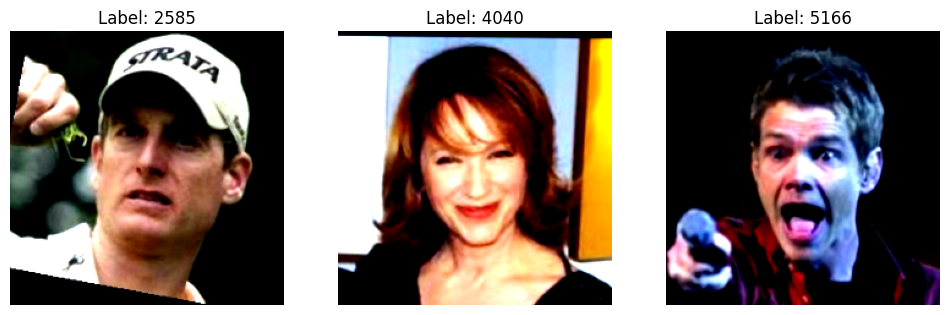

In [29]:
# Get one batch of data and view it
data_iter = iter(dataloader)
images, labels = next(data_iter)

print(f"Batch of images shape: {images.shape}") 
print(f"Batch of labels: {labels}")


# Unnormalize function 
def unnormalize(tensor):
    return tensor * 0.5 + 0.5  # Reverse normalization: (x - mean) / std -> x = x*std + mean

# Get one batch of images and labels
images, labels = next(data_iter)

# Select a few images to visualize (e.g., first 3 images in the batch)
num_images_to_show = 3
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 4))

for i in range(num_images_to_show):
    ax = axes[i]
    img = unnormalize(images[i])  # Undo normalization
    img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {labels[i]}")

plt.show()

FACE DETECTION AND ALIGNMENT USING DLIB

In [30]:
shape_pred = '../input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat'

In [33]:
#This cell may be obsolete now, will check and adjust accordingly

# Initialize dlib's face detector (HOG-based)
detector = dlib.get_frontal_face_detector()

# Load the facial landmark predictor
predictor = dlib.shape_predictor(shape_pred)

# Initialize the FaceAligner
fa = FaceAligner(predictor, desiredFaceWidth=256)

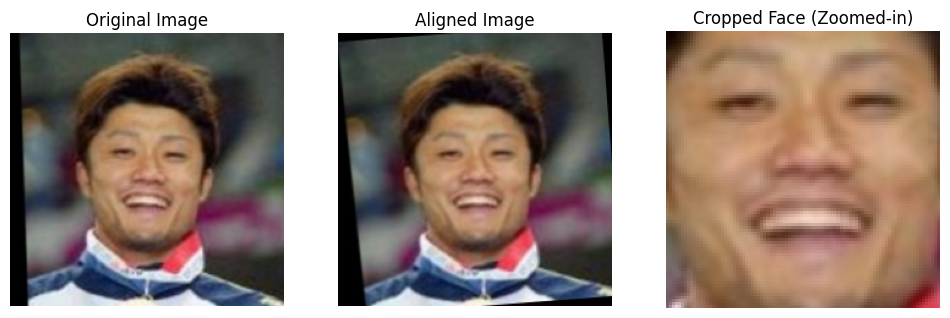

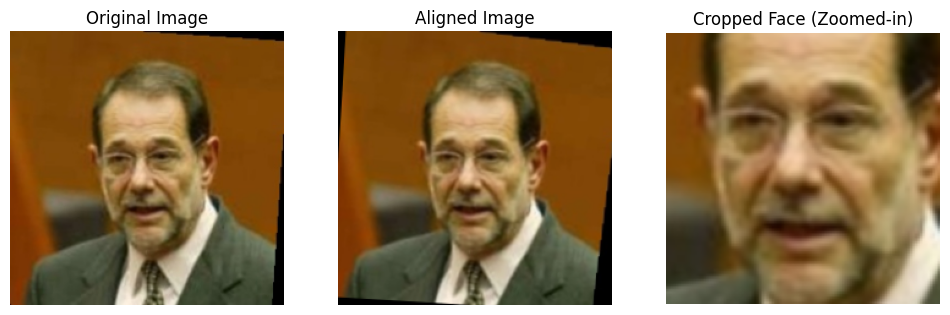

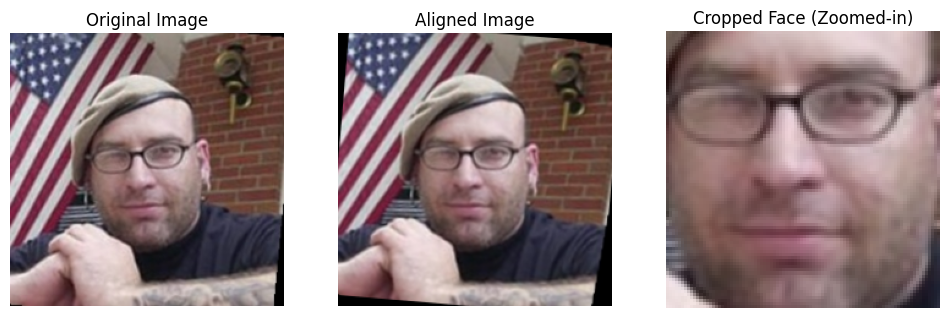

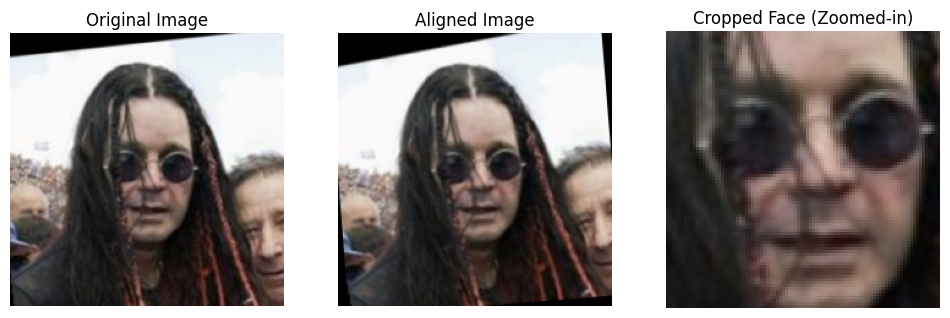

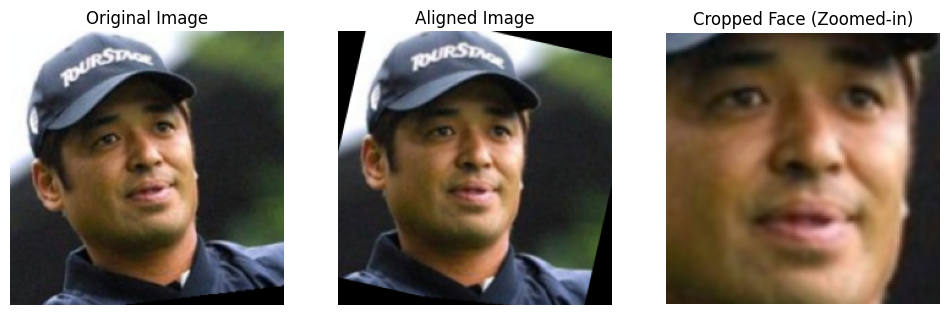

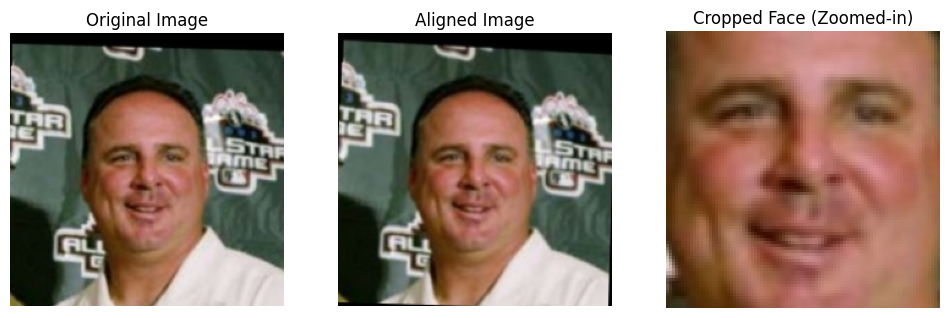

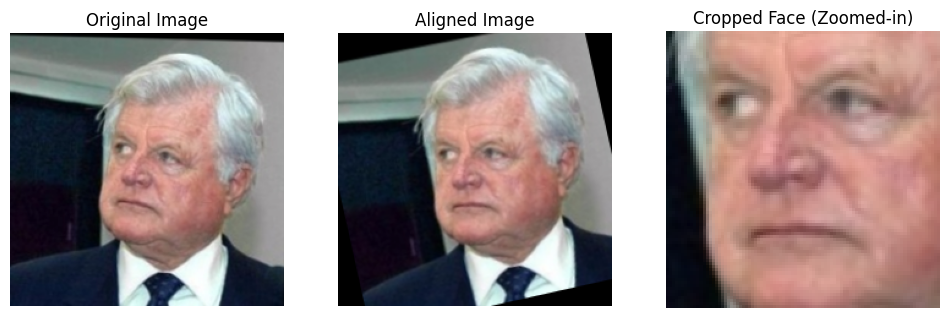

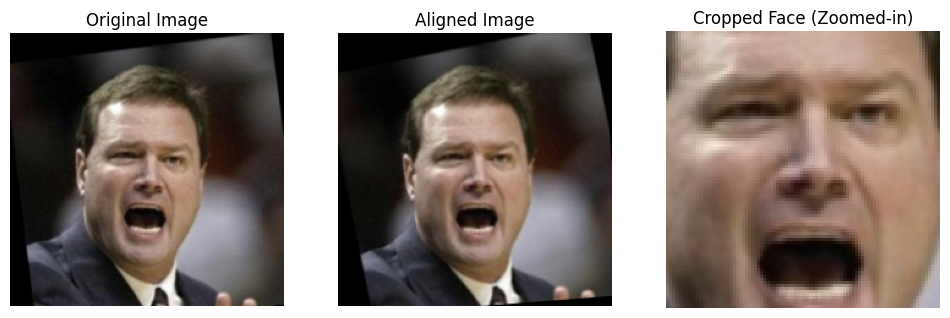

In [42]:
# Define global predictor for 68 face landmarks model
predictor68 = dlib.shape_predictor('../input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat')

# Function to perform facial landmark detection on the whole face
def facial_landmarks(image):    
    global predictor68
    
    detector = dlib.get_frontal_face_detector()
    
    # Grayscale image
    try:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        grayscale_image = image
    
    # Detect faces in the grayscale image
    rectangles = detector(grayscale_image, 1)

    # If at least one face is detected, find its landmarks
    if len(rectangles) > 0:
        # Get 68 landmark points
        faceLandmarks = predictor68(grayscale_image, rectangles[0])
        faceLandmarks = face_utils.shape_to_np(faceLandmarks)
        return faceLandmarks, rectangles[0]  # Return the landmarks and the rectangle for the face
    
    # Return None if no face is detected
    return None, None


# Function to rotate the image for face alignment
def align_face(image, eyePoints):
    # Get the coordinates for the eyes (left and right)
    leftEyeX, leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]

    # Calculate the rotation angle based on the eyes coordinates
    angle = math.atan((leftEyeY - rightEyeY) / (leftEyeX - rightEyeX)) * (180 / math.pi)
    
    # Calculate the center of the image to rotate around
    origin_point = tuple(np.array(image.shape[1::-1]) / 2)

    # Get the rotation matrix
    rot_mat = cv2.getRotationMatrix2D(origin_point, angle, 1.0)
    
    # Apply the affine rotation transformation
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


# Function to crop the face region from the image
def crop_face(image, rect):
    # Get the coordinates for the bounding box around the face
    (x, y, w, h) = (rect.left(), rect.top(), rect.width(), rect.height())
    # Crop the face from the image
    return image[y:y+h, x:x+w]

# Function to visualize and process a batch of images
def process_batch(dataloader, max_examples=5):
    # Counter to limit the number of examples
    count = 0
    
    # Iterate through the DataLoader 
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Stop if we've processed the max number of examples
        if count >= max_examples:
            break

        # Convert tensor images to numpy
        images = images.permute(0, 2, 3, 1).numpy()
        
        # Process each image in the batch
        for image in images:
            # Undo normalization and convert to uint8 for processing with OpenCV
            image = np.clip(image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # Unnormalize
            image = (image * 255).astype(np.uint8)  # Scale to [0, 255]
            
            # Convert to grayscale for OpenCV
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Detect facial landmarks and bounding box
            landmarks, face_rect = facial_landmarks(image)
            
            if landmarks is not None:
                # Select eye landmarks for alignment (left eye: 36-41, right eye: 42-47)
                eyePoints = (landmarks[36], landmarks[42])  # Using eye landmarks for alignment
                
                # Align the face using the eye landmarks
                aligned_face = align_face(image, eyePoints)
                
                # Crop the aligned face region (zoomed-in)
                cropped_face = crop_face(aligned_face, face_rect)
                
                # Display the original, aligned, and cropped face images
                plt.figure(figsize=(12, 12))

                # Original Image
                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.axis("off")

                # Aligned Image
                plt.subplot(1, 3, 2)
                plt.title("Aligned Image")
                plt.imshow(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))
                plt.axis("off")

                # Cropped Face
                plt.subplot(1, 3, 3)
                plt.title("Cropped Face (Zoomed-in)")
                plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
                plt.axis("off")

                # Show all images
                plt.show()

                # Increment the count for the number of processed examples
                count += 1

process_batch(dataloader, max_examples=3)  # Change max_examples to control how many examples to process
